# Семинар по Pytorch.

Можно выделить три уровня абстракции в Pytorch:
* Работа с тензорами и автоматическое дифференцирование
* Основные блоки: Module, Optimizer, Dataset, DataLoader
* Высокоуровневые интерфейсы (Lightning, Catalyst).

Сегодня рассмотрим первый и частично второй пункты.

В начале будет демонстрация, во второй части предлагается самостоятельно реализовать обучение SVM.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn

Установка: https://pytorch.org/get-started/locally/  
В этом ноутбуке будут разобраны основные особенности фреймворка Pytorch. Pytorch - это как Numpy, только умеет эффективно автоматически считать градиенты.

In [2]:
import torch
print (torch.__version__)

/Users/i.a.karpukhin/Library/Python/3.8/lib/python/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.13.1


In [3]:
import torchvision
from torch import nn
import os
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import tqdm

In [4]:
device = "cpu"

# проверить, доступна ли у вас CUDA. 
if torch.cuda.is_available():
    device = "cuda"
    
try:
    if torch.backends.mps.is_available():
        device = "mps"
except Exception:
    pass

print("Device:", device)

Device: mps


# Базовые операции

In [5]:
# numpy

x = np.arange(25).reshape(5, 5)

print("X :\n {}\n".format(x))
print("X.shape : {}\n ".format(x.shape))
print("Возвести в квадрат:\n {}\n".format(x * x))
print("X*X^T  :\n {}\n".format(np.matmul(x, x.T)))
print("Cреднее по столбцам :\n {}\n".format(np.mean(x, axis=0)))
print("Сумма по строкам:\n {}\n".format(np.cumsum(x, axis=1)))

X :
 [[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]

X.shape : (5, 5)
 
Возвести в квадрат:
 [[  0   1   4   9  16]
 [ 25  36  49  64  81]
 [100 121 144 169 196]
 [225 256 289 324 361]
 [400 441 484 529 576]]

X*X^T  :
 [[  30   80  130  180  230]
 [  80  255  430  605  780]
 [ 130  430  730 1030 1330]
 [ 180  605 1030 1455 1880]
 [ 230  780 1330 1880 2430]]

Cреднее по столбцам :
 [10. 11. 12. 13. 14.]

Сумма по строкам:
 [[  0   1   3   6  10]
 [  5  11  18  26  35]
 [ 10  21  33  46  60]
 [ 15  31  48  66  85]
 [ 20  41  63  86 110]]



In [6]:
# torch

x = torch.arange(25).reshape(5, 5).float()

print("X :\n {}\n".format(x))
print("X.shape : {}\n ".format(x.shape))
print("Возвести в квадрат:\n {}\n".format(x * x))
print("X*X^T  :\n {}\n".format(torch.matmul(x, x.T)))
print("Cреднее по столбцам :\n {}\n".format(torch.mean(x, axis=0)))
print("Сумма по строкам:\n {}\n".format(torch.cumsum(x, axis=1)))

X :
 tensor([[ 0.,  1.,  2.,  3.,  4.],
        [ 5.,  6.,  7.,  8.,  9.],
        [10., 11., 12., 13., 14.],
        [15., 16., 17., 18., 19.],
        [20., 21., 22., 23., 24.]])

X.shape : torch.Size([5, 5])
 
Возвести в квадрат:
 tensor([[  0.,   1.,   4.,   9.,  16.],
        [ 25.,  36.,  49.,  64.,  81.],
        [100., 121., 144., 169., 196.],
        [225., 256., 289., 324., 361.],
        [400., 441., 484., 529., 576.]])

X*X^T  :
 tensor([[  30.,   80.,  130.,  180.,  230.],
        [  80.,  255.,  430.,  605.,  780.],
        [ 130.,  430.,  730., 1030., 1330.],
        [ 180.,  605., 1030., 1455., 1880.],
        [ 230.,  780., 1330., 1880., 2430.]])

Cреднее по столбцам :
 tensor([10., 11., 12., 13., 14.])

Сумма по строкам:
 tensor([[  0.,   1.,   3.,   6.,  10.],
        [  5.,  11.,  18.,  26.,  35.],
        [ 10.,  21.,  33.,  46.,  60.],
        [ 15.,  31.,  48.,  66.,  85.],
        [ 20.,  41.,  63.,  86., 110.]])



# Pytorch - почти Numpy.
Вы можете создавать тензоры, смотреть на их градиенты, не создавая сессии как в tensorflow.
Названия методов очень похожи. Если они отличаются - загляните в таблицу: https://github.com/torch/torch7/wiki/Torch-for-Numpy-users


# Pytroch сам считает backpropagation для нас с помощью модуля autograd

In [7]:
# создаем тензор
preds = torch.zeros(5, requires_grad=True)

# вектор предсказаний
labels = torch.ones(5)

# loss: MAE
loss = torch.mean(torch.abs(labels - preds))

print(loss)

# запускаем backprop

loss.backward()

tensor(1., grad_fn=<MeanBackward0>)


In [8]:
# градиенты доступны в поле .grad:
preds.grad

tensor([-0.2000, -0.2000, -0.2000, -0.2000, -0.2000])

In [9]:
# градиенты можно занулить
preds.grad.zero_()

tensor([0., 0., 0., 0., 0.])

In [10]:
# теперь градиенты снова 0
preds.grad

tensor([0., 0., 0., 0., 0.])

###  Градиенты накапливаются при каждом вызове backward()

In [11]:
# создаем тензор
preds = torch.zeros(5, requires_grad=True)

# вектор предсказаний
labels = torch.ones(5, requires_grad=True)

# loss: MAE
loss = torch.mean(torch.abs(labels - preds))

print (loss)

# запускаем backprop
for i in range(5):
    loss.backward(retain_graph=True)
    print (i, preds.grad)

tensor(1., grad_fn=<MeanBackward0>)
0 tensor([-0.2000, -0.2000, -0.2000, -0.2000, -0.2000])
1 tensor([-0.4000, -0.4000, -0.4000, -0.4000, -0.4000])
2 tensor([-0.6000, -0.6000, -0.6000, -0.6000, -0.6000])
3 tensor([-0.8000, -0.8000, -0.8000, -0.8000, -0.8000])
4 tensor([-1., -1., -1., -1., -1.])


# Пишем свою логистическую регрессию на пайторче

In [12]:
from sklearn.datasets import make_blobs
import sklearn
X, y = make_blobs(n_samples=200, centers=((10, 5), (5, -5)), n_features=2,
                   random_state=0, cluster_std=3)

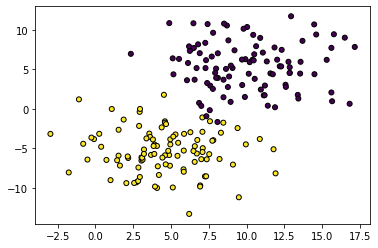

In [13]:
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y,
            s=25, edgecolor='k')

# Напоминание. Как это было в Sklearn:

In [14]:
from sklearn.linear_model import LogisticRegression

In [15]:
model = LogisticRegression()

In [16]:
model.fit(X, y)

LogisticRegression()

In [17]:
model.coef_

array([[-0.88455561, -1.38564754]])

In [18]:
model.intercept_

array([5.7855947])

## Визуализируем разделяющую плоскость

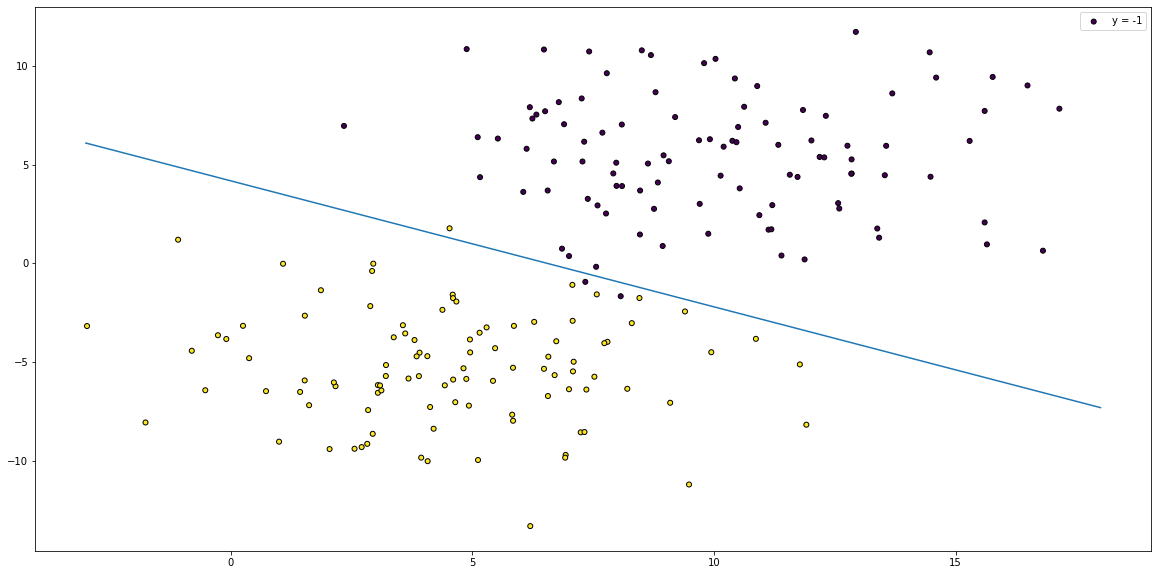

In [19]:
w_1 = model.coef_[0][0]
w_2 = model.coef_[0][1]
w_0 = model.intercept_[0]

plt.figure(figsize=(20,10))
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y,
            s=25, edgecolor='k')
plt.legend(['y = -1', 'y = 1'])
x_arr = np.linspace(-3, 18, 1000)

y_arr = -(w_0 + w_1 * x_arr) / w_2
plt.plot(x_arr, y_arr)
plt.show()

# Pytorch

In [20]:
from sklearn.datasets import make_blobs
import sklearn
X, y = make_blobs(n_samples=200, centers=((10, 5), (5, -5)), n_features=2,
                   random_state=0, cluster_std=3)

In [21]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [23]:
X = torch.tensor(X).float().to(device)
y = torch.tensor(y).to(device)

In [24]:
type(X), type(y)

(torch.Tensor, torch.Tensor)

In [25]:
print (X.shape, y.shape)

torch.Size([200, 2]) torch.Size([200])


# Напишем свою логистическую регрессию на пайторче

In [31]:
w = torch.zeros(2, requires_grad=True, device=device)
b = torch.zeros(1, requires_grad=True, device=device)

In [32]:
assert w.requires_grad
assert len(w.shape) == 1
assert w.shape[0] == X.shape[1]
assert w.dtype == X.dtype
assert b.requires_grad
assert len(b.shape) == 1
assert b.dtype == X.dtype

In [33]:
def binary_cross_entropy(y, y_predicted):
    """
    y: binary tensor, shape: N, example: [0, 1, 0, 1, 1]
    y_pred: tensor with values from 0 to 1. shape: N. example: [0.2, 0, 1, 0.75, 0.999]
    
    output: tensor, shape: N
    
    """
    return -(y * (torch.log(y_predicted)) + (1 - y) * torch.log(1 - y_predicted))

In [34]:
y_test = torch.tensor([1, 0, 1, 1])
y_pred = torch.tensor([0.7, 0.3, 0.5, 0.9])
bce_correct = torch.tensor([0.3567, 0.3567, 0.6931, 0.1054])
bce_predicted = binary_cross_entropy(y_test, y_pred)
assert bce_predicted.shape == y_test.shape
assert torch.allclose(bce_predicted, bce_correct, rtol=1e-03)

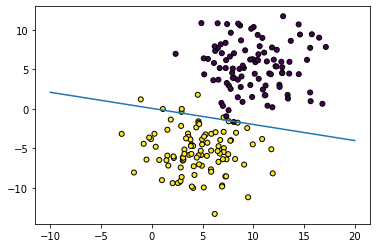

Iteration: 99, Loss: 41.97528076171875


In [41]:
from IPython.display import clear_output

for i in range(100):
    y_pred = torch.matmul(X, w) + b
    y_pred = torch.sigmoid(y_pred)
    loss = binary_cross_entropy(y, y_pred)
    loss = torch.sum(loss)
    
    loss.backward()
    
    w.data -= 0.00001 * w.grad.data
    b.data -= 0.00001 * b.grad.data

    # zero gradients
    w.grad.data.zero_()
    b.grad.data.zero_()
    
    if (i + 1) % 5==0:
        clear_output(True)
        plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), marker='o', c=y.cpu(),
            s=25, edgecolor='k')

        
        w_1 = w.data[0]
        w_2 = w.data[1]
        w_0 = b.data[0]
        
        x_arr = torch.linspace(-10, 20, 1000)
        plt.plot(x_arr, -(w_0.cpu() + w_1.cpu() * x_arr) / w_2.cpu())
        plt.show()
        
        print ("Iteration: {}, Loss: {}".format(i, loss))

# Теперь все за нас делает пайторч

# Инициализируем модель

In [49]:
model = torch.nn.Linear(2, 1).to(device)
criterion = torch.nn.BCELoss()
optim = torch.optim.SGD(model.parameters(), lr=0.001)

model.train()

Linear(in_features=2, out_features=1, bias=True)

In [50]:
model.weight

/Users/i.a.karpukhin/Library/Python/3.8/lib/python/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(


Parameter containing:
tensor([[0.3108, 0.2202]], device='mps:0', requires_grad=True)

In [51]:
model.bias

Parameter containing:
tensor([0.3253], device='mps:0', requires_grad=True)

In [52]:
model.weight.data.dtype

torch.float32

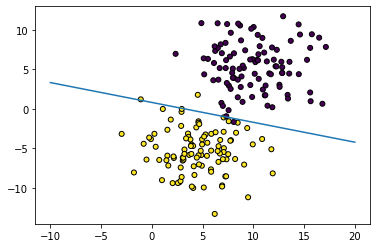

Iteration: 499, Loss: 0.15269650518894196


In [55]:
from IPython.display import clear_output


for i in range(500):
    # зануляем градиенты.
    optim.zero_grad() 
    
    # считаем предсказание.
    y_pred = torch.sigmoid(model(X))
    
    # считаем лосс.
    loss = criterion(y_pred.flatten(), y.float())
    
    # прокидываем градиенты.
    loss.backward()
    
    # делаем шаг оптимизатором.
    optim.step()     
    
    if (i + 1) % 5==0:
        clear_output(True)
        plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), marker='o', c=y.cpu(),
            s=25, edgecolor='k')

        
        w_1 = model.weight.data[0][0]
        w_2 = model.weight.data[0][1]

        w_0 = model.bias.data[0]
        
        
        x_arr = torch.linspace(-10, 20, 1000)
        plt.plot(x_arr, -(w_0.cpu() + w_1.cpu() * x_arr) / w_2.cpu())
        plt.show()
        
        print ("Iteration: {}, Loss: {}".format(i, loss))

# Окей, пусть теперь проблема нелинейная

In [56]:
from sklearn.datasets import make_moons

In [57]:
X, y = make_moons(n_samples=200, noise=.1, random_state=17)

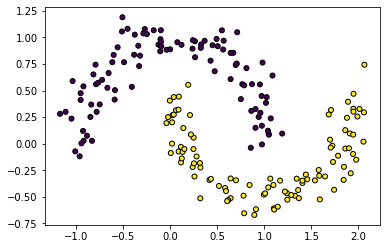

In [58]:
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y,
            s=25, edgecolor='k')

X = torch.tensor(X).float().to(device)
y = torch.tensor(y).to(device)

In [59]:
model = torch.nn.Linear(2, 1).to(device)
criterion = torch.nn.BCELoss()

optim = torch.optim.SGD(model.parameters(), lr=0.01)

model.train()

Linear(in_features=2, out_features=1, bias=True)

In [ ]:
from IPython.display import clear_output


for i in range(30000):

    y_pred = torch.sigmoid(model(X))

    loss = criterion(y_pred.flatten(), y.float())
    
    loss.backward()
    
    optim.step()           
    optim.zero_grad() 
    
    if (i+1)%500==0:
        clear_output(True)
        plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), marker='o', c=y.cpu(),
            s=25, edgecolor='k')


        w_1 = model.weight.data[0][0]
        w_2 = model.weight.data[0][1] 
        w_0 = model.bias.data[0]
        
        
        x_arr = torch.linspace(-2, 2, 1000)
        plt.plot(x_arr, -(w_0.cpu() + w_1.cpu() * x_arr) / w_2.cpu())
        plt.show()
        
        print ("Iteration: {}, Loss: {}".format(i, loss))

# Визуализируем разделяющую плоскость

In [63]:
h = .02  # step size in the mesh
cm = plt.cm.RdBu
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min.cpu(), x_max.cpu(), h),
                     np.arange(y_min.cpu(), y_max.cpu(), h))

input_tensor = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
model.eval()
Z = torch.sigmoid(model(input_tensor.to(device)))
Z = Z.reshape(xx.shape)

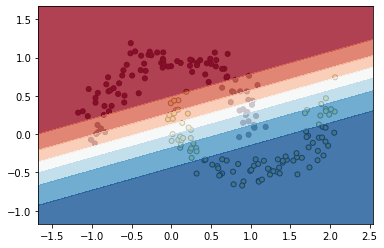

In [67]:
plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), marker='o', c=y.cpu(),
            s=25, edgecolor='k')

plt.contourf(xx, yy, Z.detach().cpu().numpy(), cmap=cm, alpha=.8)

plt.show()

# Делаем модель сложнее

In [69]:
from torch import nn

In [73]:
model = nn.Sequential(
    nn.Linear(2, 2),
    nn.Sigmoid(),
    nn.Linear(2, 1)
).to(device)

In [74]:
criterion = torch.nn.BCELoss()

optim = torch.optim.SGD(model.parameters(), lr=2.)

model.train()

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=2, out_features=1, bias=True)
)

In [ ]:
from IPython.display import clear_output


h = .02  # step size in the mesh
cm = plt.cm.RdBu
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min.cpu(), x_max.cpu(), h),
                     np.arange(y_min.cpu(), y_max.cpu(), h))



model.train()
for i in range(30000):
    
    y_pred = torch.sigmoid(model(X.float()))
        
    loss = criterion(y_pred.flatten(), y.float())
    
    loss.backward()
        
    optim.step()           
    optim.zero_grad() 
    if (i+1)%500==0:
        clear_output(True)
        input_tensor = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
        Z = torch.sigmoid(model(input_tensor.to(device)))
        Z = Z.reshape(xx.shape)

        
        plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), marker='o', c=y.cpu(),
            s=25, edgecolor='k')

        plt.contourf(xx, yy, Z.detach().cpu().numpy(), cmap=cm, alpha=.8)

        plt.show()
        
        
        print ("Iteration: {}, Loss: {}".format(i, loss))

# Усложним модель (увеличим количество слоев)

In [80]:
model = nn.Sequential(
    nn.Linear(2, 2),
    nn.Sigmoid(),
    nn.Linear(2, 2),
    nn.Sigmoid(),
    nn.Linear(2, 1)
).to(device)

In [81]:
criterion = torch.nn.BCELoss()

optim = torch.optim.SGD(model.parameters(), lr=2.)

model.train()

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=2, out_features=2, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=2, out_features=1, bias=True)
)

In [ ]:
from IPython.display import clear_output


h = .02  # step size in the mesh
cm = plt.cm.RdBu
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min.cpu(), x_max.cpu(), h),
                     np.arange(y_min.cpu(), y_max.cpu(), h))



model.train()
for i in range(30000):
    
    y_pred = torch.sigmoid(model(X))
    
    loss = criterion(y_pred.flatten(), y.float())
    
    loss.backward()
        
    optim.step()           
    optim.zero_grad() 
    if (i+1)%500==0:
        clear_output(True)
        input_tensor = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
        Z = torch.sigmoid(model(input_tensor.to(device)))
        Z = Z.reshape(xx.shape)

        
        plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), marker='o', c=y.cpu(),
            s=25, edgecolor='k')

        plt.contourf(xx, yy, Z.detach().cpu().numpy(), cmap=cm, alpha=.8)

        plt.show()
        
        
        print ("Iteration: {}, Loss: {}".format(i, loss))

# Еще усложним модель (увеличим размерность скрытых слоев) + добавим momentum

In [108]:
model = nn.Sequential(
    nn.Linear(2, 5),
    nn.Sigmoid(),
    nn.Linear(5, 5),
    nn.Sigmoid(),
    nn.Linear(5, 1),
    nn.Sigmoid()
).to(device)

In [111]:
criterion = torch.nn.BCELoss()

optim = torch.optim.SGD(model.parameters(), lr=0.2, momentum=0.9)

model.train()

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=5, out_features=5, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=5, out_features=1, bias=True)
  (5): Sigmoid()
)

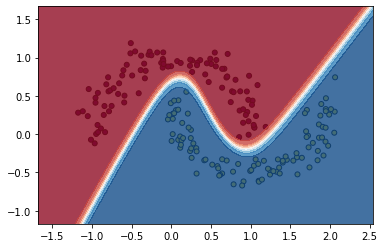

Iteration: 2999, Loss: 0.0009311368339695036


In [112]:
from IPython.display import clear_output


h = .02  # step size in the mesh
cm = plt.cm.RdBu
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min.cpu(), x_max.cpu(), h),
                     np.arange(y_min.cpu(), y_max.cpu(), h))



model.train()
for i in range(3000):

    y_pred = model(X)
        
    loss = criterion(y_pred.flatten(), y.float())
    
    loss.backward()
    
    optim.step()           
    optim.zero_grad() 
    if (i+1)%50==0:
        clear_output(True)
        input_tensor = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
        Z = torch.sigmoid(model(input_tensor.to(device)))
        Z = Z.reshape(xx.shape)

        
        plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), marker='o', c=y.cpu(),
            s=25, edgecolor='k')

        plt.contourf(xx, yy, Z.detach().cpu().numpy(), cmap=cm, alpha=.8)

        plt.show()
        print ("Iteration: {}, Loss: {}".format(i, loss))

# Сделаем > 2 классов

In [114]:
from sklearn.datasets import make_circles

In [115]:
# blobs with varied variances
X, y = make_blobs(n_samples=400,
                  cluster_std=[1.0, 1.5, 0.5],
                  random_state=17)

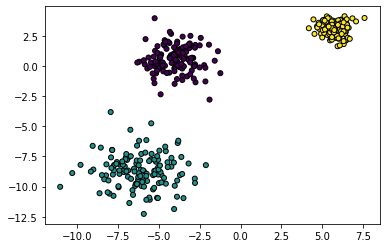

In [116]:
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y,
            s=25, edgecolor='k')

X = torch.tensor(X).float().to(device)
y = torch.tensor(y).to(device)

In [117]:
model = nn.Sequential(
    nn.Linear(2, 5),
    nn.Sigmoid(),
    nn.Linear(5, 5),
    nn.Sigmoid(), 
    nn.Linear(5, 3)
).to(device)

In [118]:
criterion = torch.nn.CrossEntropyLoss()

optim = torch.optim.SGD(model.parameters(), lr=0.1)

model.train()

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=5, out_features=5, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=5, out_features=3, bias=True)
)

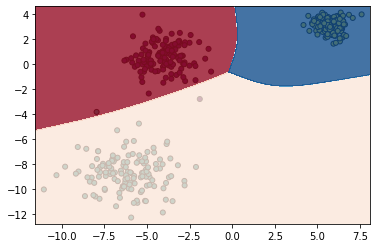

Iteration: 999, Loss: 0.04780852049589157


In [119]:
from IPython.display import clear_output


h = .02  # step size in the mesh
cm = plt.cm.RdBu
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min.cpu(), x_max.cpu(), h),
                     np.arange(y_min.cpu(), y_max.cpu(), h))



model.train()
for i in range(1000):
    
    y_pred = model(X)
    
    loss = criterion(y_pred, y)
    
    loss.backward()
    
    optim.step()           
    optim.zero_grad() 
    if (i+1)%25==0:
        clear_output(True)
        input_tensor = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
        Z = model(input_tensor.to(device))
        Z = torch.argmax(Z, axis=1)
        Z = Z.reshape(xx.shape)
        
        plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), marker='o', c=y.cpu(),
            s=25, edgecolor='k')

        plt.contourf(xx, yy, Z.detach().cpu().numpy(), cmap=cm, alpha=.8)
        
        plt.show()
        
        
        print ("Iteration: {}, Loss: {}".format(i, loss))